# Economic Diversity and Student Outcomes

For #tidytuesday week 37, we are going to investigate the relationship between economic diversity and student outcomes in a dataset provided by [Havisha Khurana](https://github.com/havishak) via:

Org: [Opportunity Insights](https://opportunityinsights.org/data/)

Article: [Interactive visualization](https://www.nytimes.com/interactive/2017/01/18/upshot/some-colleges-have-more-students-from-the-top-1-percent-than-the-bottom-60.html)

[Interactive visualization here](https://www.nytimes.com/interactive/projects/college-mobility/university-of-texas-at-dallas)

Some information from the source:

> A new study, based on millions of anonymous tax records, shows that some colleges are even more economically segregated than previously understood, while others are associated with income mobility.

A key goal of this week's analysis has to do with what makes a dataset truly [tidy](https://r4ds.hadley.nz/data-tidy#sec-tidy-data):

1. Each variable is a column; each column is a variable.
2. Each observation is a row; each row is an observation.
3. Each value is a cell; each cell is a single value.

Let's go!

## Setup

In [2]:
# installation
using Pkg
Pkg.add(["DataFrames", "CSV", "HTTP", "StatsPlots",
    "StatsBase", "Plots", "SummaryTables", "DataFramesMeta",
    "Chain", "CategoricalArrays", "Measures", "PlotThemes"
])

# load
using DataFrames, CSV, HTTP, StatsPlots, StatsBase, Plots, SummaryTables, DataFramesMeta, Chain, CategoricalArrays, Measures, PlotThemes

   Resolving package versions...
  No Changes to `C:\Users\ndfos\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ndfos\.julia\environments\v1.10\Manifest.toml`


## Data

In [3]:
# Load the dataset
url = "https://opportunityinsights.org/wp-content/uploads/2023/07/CollegeAdmissions_Data.csv"

# file
response = HTTP.get(url)

# import
college_admissions = CSV.read(response.body, DataFrame);

In [4]:
# describe the raw DataFrame

describe(college_admissions)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,super_opeid,2528.51,108,2536.0,11649,0,Int64
2,name,,American University,,Yeshiva University,0,String
3,par_income_bin,78.1714,10.0,94.0,100.0,0,Float64
4,par_income_lab,,0-20,,Top 1,0,String7
5,attend,0.00482567,2.88504e-5,0.00303171,0.0460693,2,"Union{Missing, Float64}"
6,stderr_attend,0.000353691,0.0,0.000205173,0.00540242,0,Float64
7,attend_level,0.0040984,0.000420824,0.00256485,0.0201221,0,Float64
8,attend_sat,0.00400884,1.6128e-5,0.00235861,0.0423259,294,"Union{Missing, Float64}"
9,stderr_attend_sat,0.00048375,0.0,0.000313297,0.00374723,278,"Union{Missing, Float64}"


In [5]:
# how many unique parent income brackets are there?

length(unique(college_admissions.par_income_lab))

14

In [6]:
# see unique levels of the parent income labels

unique(college_admissions.par_income_lab)

14-element Vector{String7}:
 "0-20"
 "20-40"
 "40-60"
 "60-70"
 "70-80"
 "80-90"
 "90-95"
 "95-96"
 "96-97"
 "97-98"
 "98-99"
 "99-99.9"
 "Top 1"
 "Top 0.1"

## Cleaning

We'll clean the data similarly to the R code. Dropping the redundant "tier_name" variable and recoding the public and flagship columns.

In [88]:
college_admissions_clean = @chain begin
    college_admissions
    select(Not(:tier_name))  # Drop redundant variable
    transform(:public => ByRow(==("Public")) => :public)  # Recode public as boolean
    transform(:flagship => ByRow(Bool) => :flagship)  # Recode flagship as boolean
end;

### Try visualizing the data in the native format

In [185]:
# summarize averages

# tier and parent income
college_admissions_summary = @chain begin
    college_admissions_clean
    filter(:par_income_lab => x -> !(x in ["Top 0.1", "Top 1"]), _)
    groupby([:tier, :par_income_lab])
    @combine(:avg_rel_attend = mean(:rel_attend),
        :avg_rel_apply = mean(:rel_apply);
        ungroup=true
    )
    @transform(:tier = ifelse.(:tier .== "Other elite schools (public and private)", "Other elite schools\n(public and private)", :tier))
end

# tier
college_admissions_summary_tier = @chain begin
    college_admissions_clean
    filter(:par_income_lab => x -> !(x in ["Top 0.1", "Top 1"]), _)
    groupby(:tier)
    @combine(:avg_rel_attend = mean(:rel_attend),
             :avg_rel_apply = mean(:rel_apply);
             ungroup = true
    )
    @transform(:tier = ifelse.(:tier .== "Other elite schools (public and private)", "Other elite schools\n(public and private)", :tier))
end    

# parent income
college_admissions_summary_income = @chain begin
    college_admissions_clean
    filter(:par_income_lab => x -> !(x in ["Top 0.1", "Top 1"]), _)
    groupby(:par_income_lab)
    @combine(:avg_rel_attend = mean(:rel_attend),
        :avg_rel_apply = mean(:rel_apply);
        ungroup=true
    )
end;

### Plot

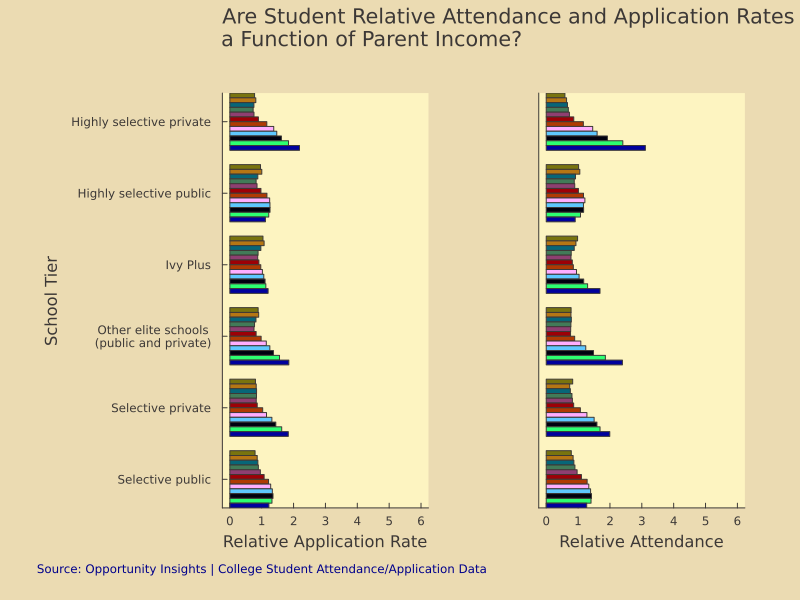

In [186]:
# plot long format 
theme(:gruvbox_light)  # Apply gruvbox theme

# Plotting side-by-side bars with divisions based on `avg_rel_attend`
college_admissions_summary_attend = @df college_admissions_summary groupedbar(:tier, :avg_rel_attend,
    group=:par_income_lab,
    title="",
    xlabel="",
    xticks = false,
    ylabel="Relative Attendance",
    permute=(:x, :y),
    size=(800, 600),
    grid=false,
    titlealign=:left,
    legend=false,
    legendtitle="Parent Income Bin",
    margins=12mm
)
yflip!()

# Plotting side-by-side bars with divisions based on `avg_rel_apply`
college_admissions_summary_apply = @df college_admissions_summary groupedbar(:tier, :avg_rel_apply,
    group=:par_income_lab,
    title="Are Student Relative Attendance and Application Rates\na Function of Parent Income?",
    xlabel="School Tier",
    ylabel="Relative Application Rate",
    permute=(:x, :y),
    size=(800, 600),
    grid=false,
    titlealign=:left,
    legend=false,
    legendtitle="Parent Income Bin", 
    margins = 12mm
)
yflip!()
annotate!(1, 6.75, text("Source: Opportunity Insights | College Student Attendance/Application Data", :darkblue, 8))

plot_vector = [college_admissions_summary_apply, college_admissions_summary_attend]

plot(plot_vector...)


## Next steps!

The plot above shows how it can be more effective to utilize a pivot long format for summarized data.  It is difficult to read and inserting a legend would be messy.

Now, we have a cleaned dataset and visualized the data - we will now pivot long.  Let's create a few visualizations for the long format that can help us understand economic diversity and student outcomes.

## Visualization: Long Format (`rel_attend` and `rel_apply`)
We can use a combined bar plot to visualize the distribution of the average `rel_attend` and `rel_apply` values across schools, grouped by the income bins (`par_income_lab`) and `tier`s, for example. This will provide insights into the trends in each group.

* Theme: `gruvbox_light` from `PlotThemes.jl`

## Pivot the Data
Now, we can use the `@chain` macro for both long pivoting.

### Long Format

In [188]:
# tier
long_college_admissions_summary_tier = @chain begin
    college_admissions_summary_tier
    stack([:avg_rel_attend, :avg_rel_apply])
    select([:tier, :variable, :value])
end

describe(long_college_admissions_summary_tier)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,tier,,Highly selective private,,Selective public,0,String
2,variable,,avg_rel_apply,,avg_rel_attend,0,String
3,value,1.1161,1.01409,1.10766,1.31948,0,Float64


In [189]:
# parent income
long_college_admissions_summary_income = @chain begin
    college_admissions_summary_income
    stack([:avg_rel_attend, :avg_rel_apply])
    select([:par_income_lab, :variable, :value])
end

describe(long_college_admissions_summary_income)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,par_income_lab,,0-20,,99-99.9,0,String7
2,variable,,avg_rel_apply,,avg_rel_attend,0,String
3,value,1.11469,0.806557,0.977198,1.9737,0,Float64


## Plot using pivoted data

It's much cleaner!

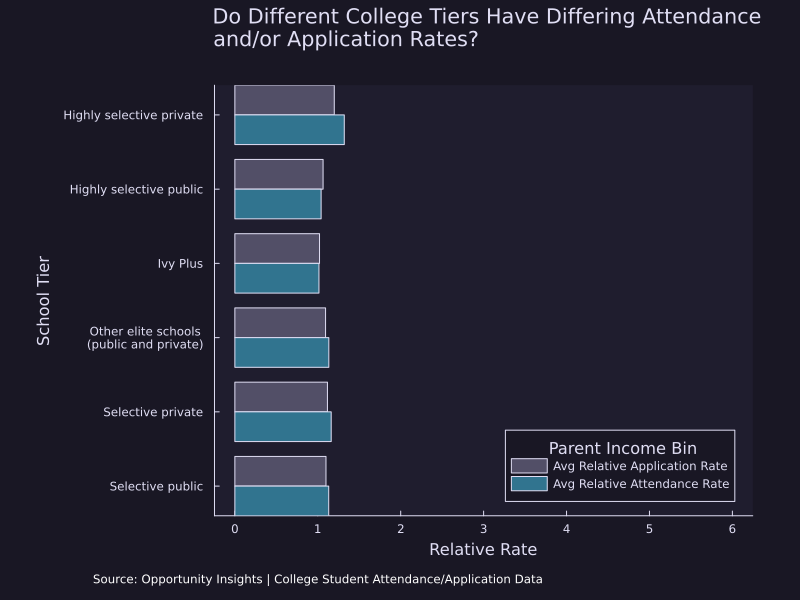

In [202]:
# Plotting side-by-side bars with divisions based on `avg_rel_apply`

theme(:rose_pine)

college_admissions_summary_bar_tier = @df long_college_admissions_summary_tier groupedbar(:tier, :value,
    group=:variable,
    title="Do Different College Tiers Have Differing Attendance\nand/or Application Rates?",
    xlabel="School Tier",
    ylabel="Relative Rate",
    permute=(:x, :y),
    size=(800, 600),
    grid=false,
    titlealign=:left,
    legend=:bottomright,
    labels = ["Avg Relative Application Rate" "Avg Relative Attendance Rate"],
    legendtitle="Parent Income Bin",
    margins=10mm
)
yflip!()
annotate!(1, 6.75, text("Source: Opportunity Insights | College Student Attendance/Application Data", :white, 8))


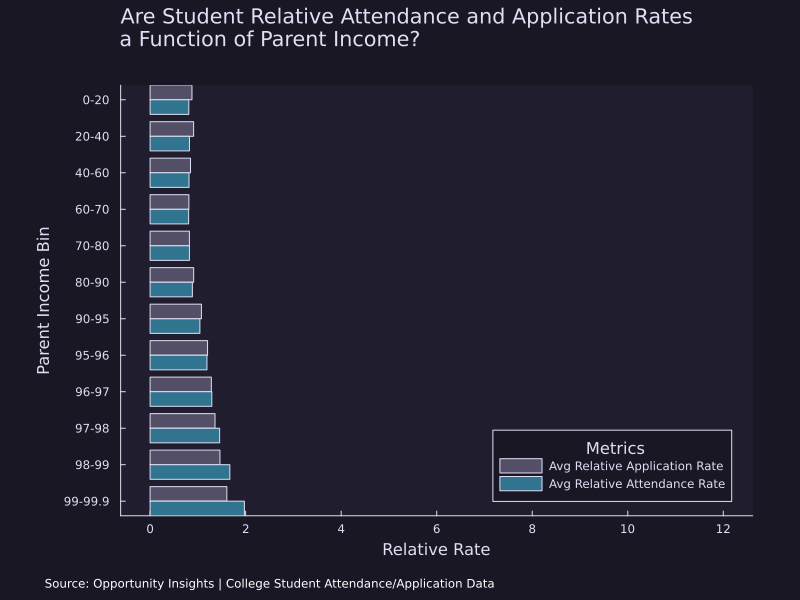

In [200]:
theme(:rose_pine)

college_admissions_summary_bar_income = @df long_college_admissions_summary_income groupedbar(:par_income_lab, :value,
    group=:variable,
    title="Are Student Relative Attendance and Application Rates\na Function of Parent Income?",
    xlabel="Parent Income Bin",
    ylabel="Relative Rate",
    permute=(:x, :y),
    size=(800, 600),
    grid=false,
    titlealign=:left,
    legend=:bottomright,
    labels=["Avg Relative Application Rate" "Avg Relative Attendance Rate"],
    legendtitle="Metrics",
    margins=10mm
)
yflip!()
annotate!(2.5, 13.75, text("Source: Opportunity Insights | College Student Attendance/Application Data", :white, 8))